# Setup

Clone repo, install dependencies and check PyTorch and GPU.

In [1]:
!pip install pydicom

     |████████████████████████████████| 1.9 MB 7.1 MB/s 


In [2]:
import math
import os
import shutil
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pydicom
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
from IPython.display import Image, clear_output  # to display images


In [3]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt  # install dependencies

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.9.0+cu102 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


# 1. Inference

`detect.py` runs inference on a variety of sources, downloading models automatically from the [latest YOLOv5 release](https://github.com/ultralytics/yolov5/releases).

detect: weights=['yolov5x.pt'], source=data/images/, imgsz=640, conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-304-g2c073cd torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

100% 168M/168M [00:01<00:00, 105MB/s]

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 476 layers, 87730285 parameters, 0 gradients
image 1/2 /

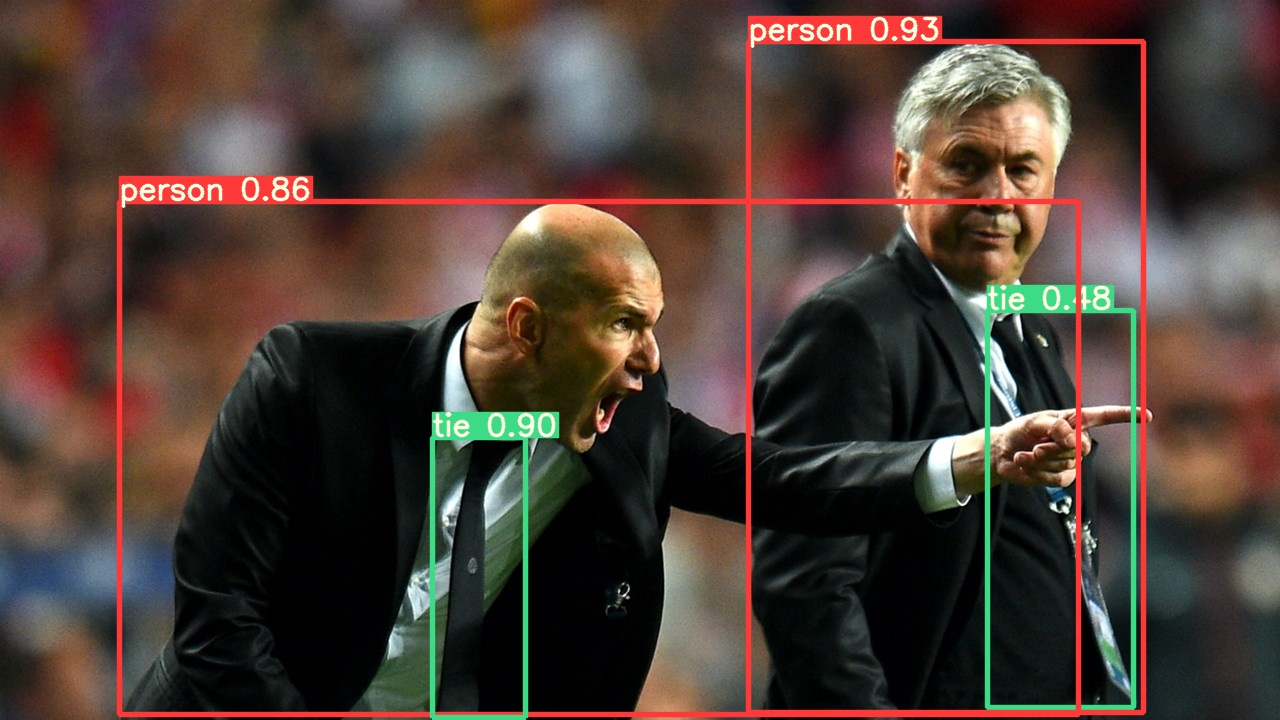

In [4]:
!python detect.py --weights yolov5x.pt --img 640 --conf 0.25 --source data/images/
Image(filename='runs/detect/exp/zidane.jpg', width=600)

Results are saved to `runs/detect`. A full list of available inference sources:
<img src="https://user-images.githubusercontent.com/26833433/98274798-2b7a7a80-1f94-11eb-91a4-70c73593e26b.jpg" width="900"> 

##Copiando os arquivos##
**Não funciona se tentar baixar diretamente. É preciso baixar e subir para o drive e alterar o diretório abaixo**

In [ ]:
# Download RSNA

from google.colab import drive
drive.mount('/content/drive')

# Link para o rsna
https://drive.google.com/uc?export=download&confirm=Azk1&id=1g_epyjg1UaguV8e8D9CuhDJCDfCuTv5F

# link alternativo
https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data

# link alternativo
https://www.rsna.org/education/ai-resources-and-training/ai-image-challenge/rsna-pneumonia-detection-challenge-2018


"""Não funciona se tentar baixar diretamente.
   É preciso baixar e subir para o drive e alterar o diretório abaixo.
"""


**Diretório a ser alterado**
**"/content/drive/MyDrive/Mestrado/Projetos/Challenge Covid-19/RSNA/rsna-pneumonia-detection-challenge.zip"**

In [ ]:
!unzip -uq "/content/drive/MyDrive/Mestrado/Projetos/Challenge Covid-19/RSNA/rsna-pneumonia-detection-challenge.zip" -d "/content/RSNA/"

##Convertendo os valores das labels para o formato da yolo##

In [ ]:
DATA_DIR = "/content/RSNA/"

train_dcm_dir = os.path.join(DATA_DIR, "stage_2_train_images")
test_dcm_dir = os.path.join(DATA_DIR, "stage_2_test_images")

img_dir = os.path.join(os.getcwd(), "images")  # .jpg
label_dir = os.path.join(os.getcwd(), "labels")  # .txt
metadata_dir = os.path.join(os.getcwd(), "metadata") # .txt

# YOLOv3 config file directory
cfg_dir = os.path.join(os.getcwd(), "cfg")
# YOLOv3 training checkpoints will be saved here
backup_dir = os.path.join(os.getcwd(), "backup")

for directory in [img_dir, label_dir, metadata_dir, cfg_dir, backup_dir]:
    if os.path.isdir(directory):
        continue
    os.mkdir(directory)

In [ ]:
def save_img_from_dcm(dcm_dir, img_dir, patient_id):
    img_fp = os.path.join(img_dir, "{}.png".format(patient_id))
    if os.path.exists(img_fp):
        return
    dcm_fp = os.path.join(dcm_dir, "{}.dcm".format(patient_id))
    img_1ch = pydicom.read_file(dcm_fp).pixel_array
    img_3ch = np.stack([img_1ch]*3, -1)

    img_fp = os.path.join(img_dir, "{}.png".format(patient_id))
    cv2.imwrite(img_fp, img_3ch)
    
def save_label_from_dcm(label_dir, patient_id, row=None):
    # rsna defualt image size
    img_size = 1024
    label_fp = os.path.join(label_dir, "{}.txt".format(patient_id))
    
    f = open(label_fp, "a")
    if row is None:
        f.close()
        return

    top_left_x = row[1]
    top_left_y = row[2]
    w = row[3]
    h = row[4]
    
    # 'r' means relative. 'c' means center.
    rx = top_left_x/img_size
    ry = top_left_y/img_size
    rw = w/img_size
    rh = h/img_size
    rcx = rx+rw/2
    rcy = ry+rh/2
    
    line = "{} {} {} {} {}\n".format(0, rcx, rcy, rw, rh)
    
    f.write(line)
    f.close()
        
def save_yolov3_data_from_rsna(dcm_dir, img_dir, label_dir, annots):
    for row in tqdm(annots.values):
        patient_id = row[0]

        img_fp = os.path.join(img_dir, "{}.png".format(patient_id))
        if os.path.exists(img_fp):
            save_label_from_dcm(label_dir, patient_id, row)
            continue

        target = row[5]
        # Since kaggle kernel have samll volume (5GB ?), I didn't contain files with no bbox here.
        if target == 0:
            continue
        save_label_from_dcm(label_dir, patient_id, row)
        save_img_from_dcm(dcm_dir, img_dir, patient_id)

In [ ]:
annots = pd.read_csv(os.path.join(DATA_DIR, "stage_2_train_labels.csv"))
annots.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [ ]:
save_yolov3_data_from_rsna(train_dcm_dir, img_dir, label_dir, annots)

100%|██████████| 30227/30227 [05:01<00:00, 100.19it/s]


In [ ]:
!du -sh images labels

5.3G	images
24M	labels


**Plotando uma sample**

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125



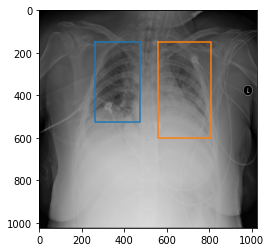

In [ ]:
ex_patient_id = annots[annots.Target == 1].patientId.values[0]
ex_img_path = os.path.join(img_dir, "{}.png".format(ex_patient_id))
ex_label_path = os.path.join(label_dir, "{}.txt".format(ex_patient_id))

plt.imshow(cv2.imread(ex_img_path))

img_size = 1014
with open(ex_label_path, "r") as f:
    for line in f:
        print(line)
        class_id, rcx, rcy, rw, rh = list(map(float, line.strip().split()))
        x = (rcx-rw/2)*img_size
        y = (rcy-rh/2)*img_size
        w = rw*img_size
        h = rh*img_size
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])

**Gerando um arquivo contendo os arquivos de treino e validação**

In [ ]:
random_stat = 123
np.random.seed(random_stat)

In [ ]:
def write_train_list(metadata_dir, img_dir, name, series):
    list_fp = os.path.join(metadata_dir, name)
    with open(list_fp, "w") as f:
        for patient_id in series:
            line = "{}\n".format(os.path.join(img_dir, "{}.png".format(patient_id)))
            f.write(line)

In [ ]:
# Following lines do not contain data with no bbox
patient_id_series = annots[annots.Target == 1].patientId.drop_duplicates()

tr_series, val_series = train_test_split(patient_id_series, test_size=0.1, random_state=random_stat)
print("The # of train set: {}, The # of validation set: {}".format(tr_series.shape[0], val_series.shape[0]))

# train image path list
write_train_list(metadata_dir, img_dir, "tr_list.txt", tr_series)
# validation image path list
write_train_list(metadata_dir, img_dir, "val_list.txt", val_series)

The # of train set: 5410, The # of validation set: 602


**Criando o conjunto de teste**

In [ ]:
def save_yolov3_test_data(test_dcm_dir, img_dir, metadata_dir, name, series):
    list_fp = os.path.join(metadata_dir, name)
    with open(list_fp, "w") as f:
        for patient_id in series:
            save_img_from_dcm(test_dcm_dir, img_dir, patient_id)
            line = "{}\n".format(os.path.join(img_dir, "{}.png".format(patient_id)))
            f.write(line)

In [ ]:
test_dcm_fps = list(set(glob.glob(os.path.join(test_dcm_dir, '*.dcm'))))
test_dcm_fps = pd.Series(test_dcm_fps).apply(lambda dcm_fp: dcm_fp.strip().split("/")[-1].replace(".dcm",""))

save_yolov3_test_data(test_dcm_dir, img_dir, metadata_dir, "te_list.txt", test_dcm_fps)

**Plotando uma sample de teste**

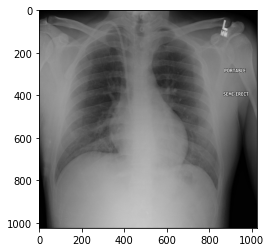

In [ ]:
ex_patient_id = test_dcm_fps[0]
ex_img_path = os.path.join(img_dir, "{}.png".format(ex_patient_id))

plt.imshow(cv2.imread(ex_img_path))

In [ ]:
!zip -r /content/yolov5/images.zip /content/yolov5/images/

A saída de streaming foi truncada nas últimas 5000 linhas.
  adding: content/yolov5/images/3a776e35-1909-4109-aa86-0fd23f023e44.png (deflated 23%)
  adding: content/yolov5/images/3e68ba7b-58ae-4415-a4e0-1698e03c4489.png (deflated 24%)
  adding: content/yolov5/images/90b1ce86-6956-4957-a33f-280c1354db0d.png (deflated 25%)
  adding: content/yolov5/images/ab17c7e8-3447-431f-afcd-efec89229fe2.png (deflated 23%)
  adding: content/yolov5/images/3c92c85a-acb7-49dc-b732-1b6e203e6d7b.png (deflated 23%)
  adding: content/yolov5/images/a6cbb3dd-75ab-4671-a6b0-9a51c04a81ec.png (deflated 21%)
  adding: content/yolov5/images/11ba8217-4fcc-4da8-a748-476260d6b3c6.png (deflated 25%)
  adding: content/yolov5/images/44b62adf-2f05-4c3d-9bde-ec2994668c3f.png (deflated 24%)
  adding: content/yolov5/images/27cf448c-36b9-4ee0-ad14-dcf350f564b7.png (deflated 23%)
  adding: content/yolov5/images/7d1b94bf-9fb6-4191-bf69-09549b4a3b96.png (deflated 23%)
  adding: content/yolov5/images/9aa7e15e-45ea-4d4f-a5eb-97f02

In [ ]:
!zip -r /content/yolov5/labels.zip /content/yolov5/labels

A saída de streaming foi truncada nas últimas 5000 linhas.
  adding: content/yolov5/labels/93550df9-7f67-404f-a974-516acecd5c48.txt (deflated 15%)
  adding: content/yolov5/labels/129a1251-95cf-4663-91ad-4e58bc0b2d08.txt (deflated 20%)
  adding: content/yolov5/labels/56879516-a43e-49f8-a482-8df58d7c4c3b.txt (deflated 20%)
  adding: content/yolov5/labels/ccb10edf-bdb8-4022-b6ce-c131dee4541b.txt (deflated 20%)
  adding: content/yolov5/labels/bce0b118-a130-47a3-bfa6-d5b68ac6b8e2.txt (deflated 19%)
  adding: content/yolov5/labels/fa8ea2ce-097a-4e42-8f9b-c3d0603484f1.txt (deflated 35%)
  adding: content/yolov5/labels/a0fc511b-7483-46a6-9591-46f6c73f87e9.txt (deflated 37%)
  adding: content/yolov5/labels/ac1426c4-11ff-485c-a0bb-790bd57d0527.txt (deflated 37%)
  adding: content/yolov5/labels/19a62d7a-3d7d-4b5b-8dca-3247af94f339.txt (deflated 18%)
  adding: content/yolov5/labels/01d4fa0f-97a0-4522-b0d8-134400db2a3e.txt (deflated 39%)
  adding: content/yolov5/labels/c39c065c-40fb-4920-9f9a-36ccb

In [ ]:
!zip -r /content/yolov5/metadados.zip /content/yolov5/metadata/

  adding: content/yolov5/metadata/ (stored 0%)
  adding: content/yolov5/metadata/val_list.txt (deflated 64%)
  adding: content/yolov5/metadata/tr_list.txt (deflated 64%)
  adding: content/yolov5/metadata/te_list.txt (deflated 65%)


In [ ]:
from google.colab import files
files.download("/content/yolov5/images.zip")

In [ ]:
files.download("/content/yolov5/labels.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("/content/yolov5/metadados.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!rm -r "/content/RSNA"

##Alterando o arquivo de configurações para o número de classes corretas##

In [ ]:
contents = '''

# COCO 2017 dataset http://cocodataset.org
# Train command: python train.py --data coco.yaml
# Default dataset location is next to /yolov5:
#   /parent_folder
#     /coco
#     /yolov5


# download command/URL (optional)
#download: bash data/scripts/get_coco.sh

# train and val data as 1) directory: path/images/, 2) file: path/images.txt, or 3) list: [path1/images/, path2/images/]
train: /content/yolov5/metadata/tr_list.txt  # 118287 images
val: /content/yolov5/metadata/val_list.txt  # 5000 images
test: /content/yolov5/metadata/te_list.txt  # 20288 of 40670 images

# number of classes
nc: 1

# class names
names: [ 'pneumonia' ]

# Print classes
# with open('data/coco.yaml') as f:
#   d = yaml.load(f, Loader=yaml.FullLoader)  # dict
#   for i, x in enumerate(d['names']):
#     print(i, x)
'''

f = open('/content/yolov5/cfg/rsna.yaml','w')
f.write(contents)
f.close()


##Alterando o arquivo de treino##

In [ ]:
content  = '''
# parameters
nc: 1  # number of classes
depth_multiple: 1.33  # model depth multiple
width_multiple: 1.25  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]
'''
f = open('/content/yolov5/cfg/rsna_cfg.yaml','w')
f.write(content)
f.close()

##Treinando##

In [ ]:
!python train.py --img 320 --batch 48 --epochs 100 --data /content/yolov5/cfg/rsna.yaml --weights '' --cfg /content/yolov5/cfg/rsna_cfg.yaml --cache --adam --linear-lr 

In [ ]:
!cp -r "/content/yolov5/runs/train/exp" "/content/drive/MyDrive/Mestrado/Projetos/Challenge Covid-19/RSNA/Teste_10-03_Scratch"

# 3. Visualize

## Local Logging

All results are logged by default to `runs/train`, with a new experiment directory created for each new training as `runs/train/exp2`, `runs/train/exp3`, etc. View train and test jpgs to see mosaics, labels, predictions and augmentation effects. Note a **Mosaic Dataloader** is used for training (shown below), a new concept developed by Ultralytics and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

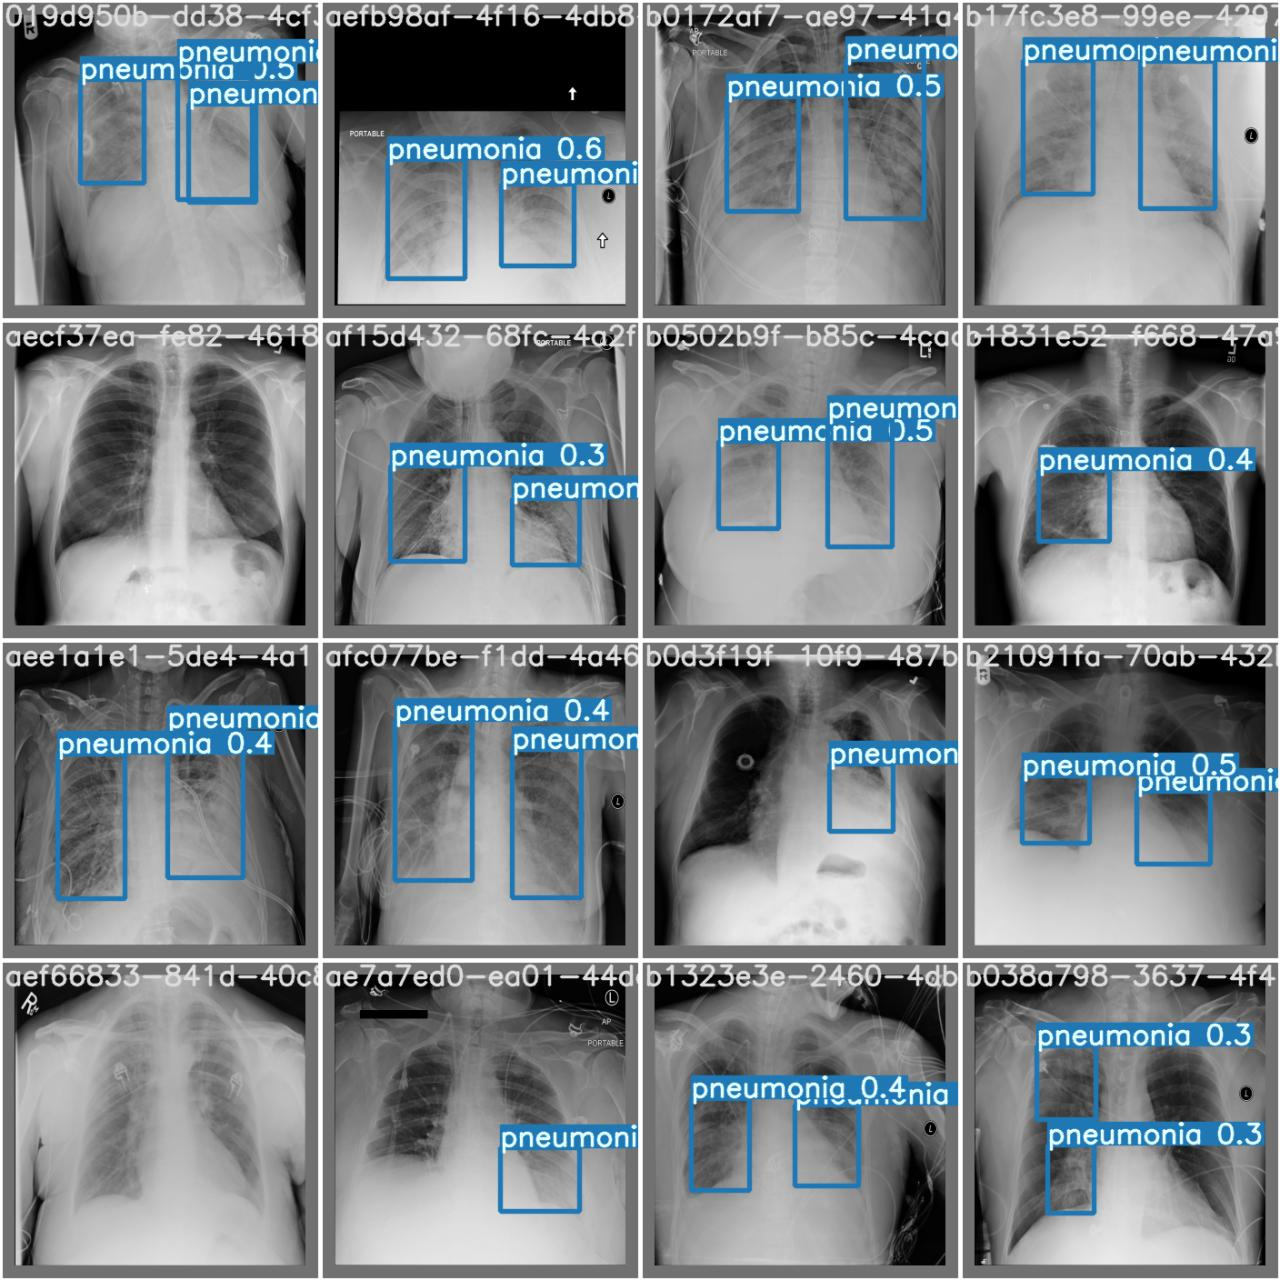

In [ ]:
#Image(filename='runs/train/exp3/train_batch0.jpg', width=800)  # train batch 0 mosaics and labels
#Image(filename='runs/train/exp3/test_batch0_labels.jpg', width=800)  # test batch 0 labels
Image(filename='runs/train/exp3/test_batch0_pred.jpg', width=800)  # test batch 0 predictions

Training losses and performance metrics are also logged to [Tensorboard](https://www.tensorflow.org/tensorboard) and a custom `results.txt` logfile which is plotted as `results.png` (below) after training completes. Here we show YOLOv5s trained on COCO128 to 300 epochs, starting from scratch (blue), and from pretrained `--weights yolov5s.pt` (orange).

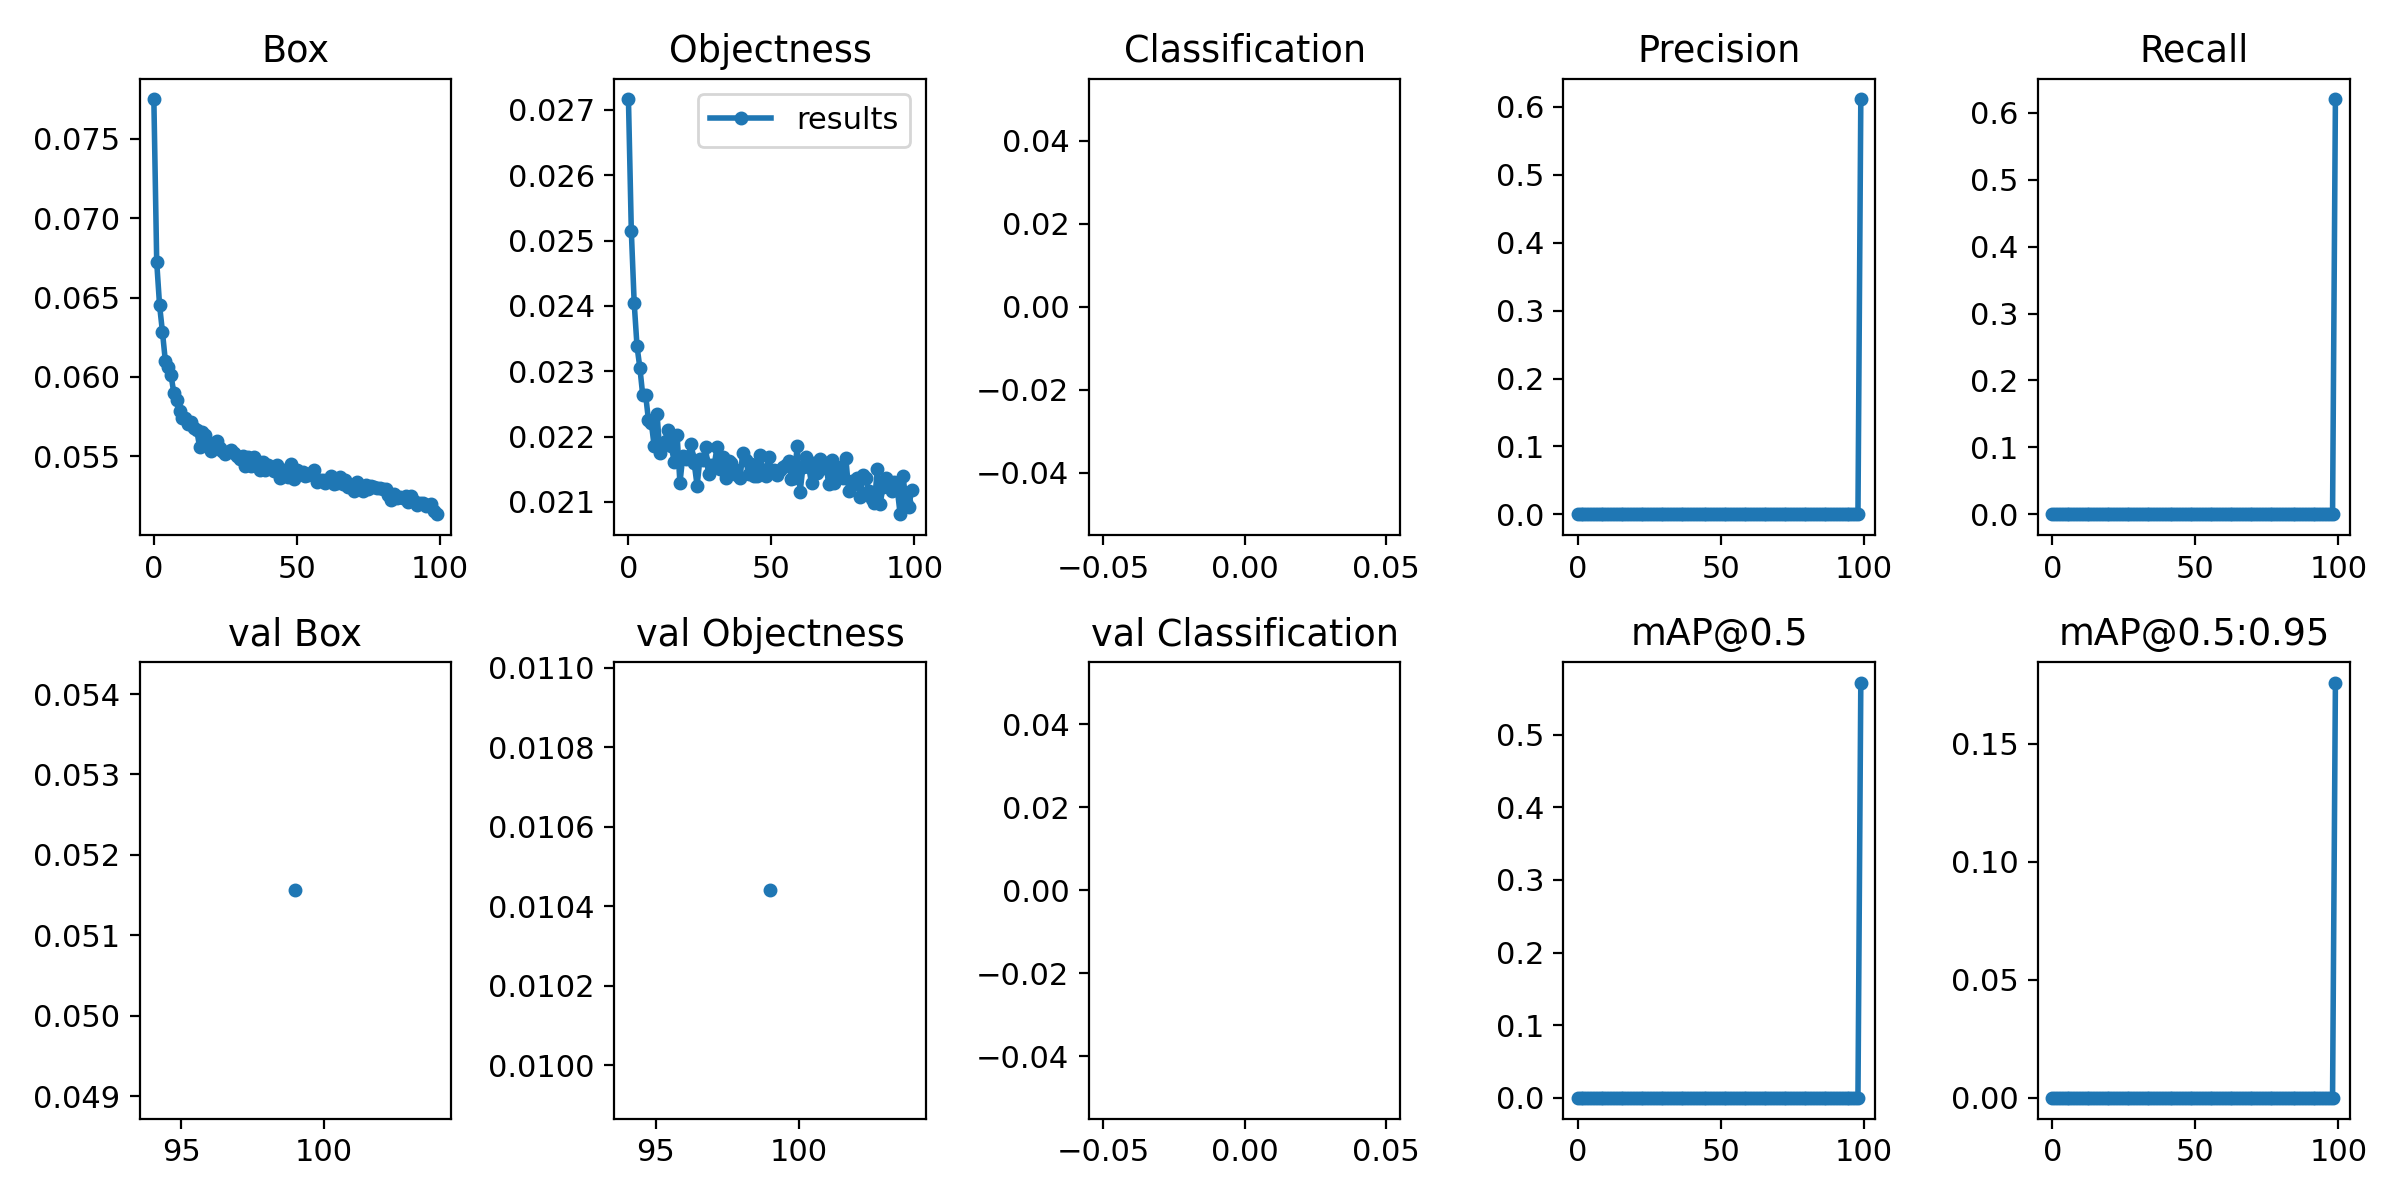

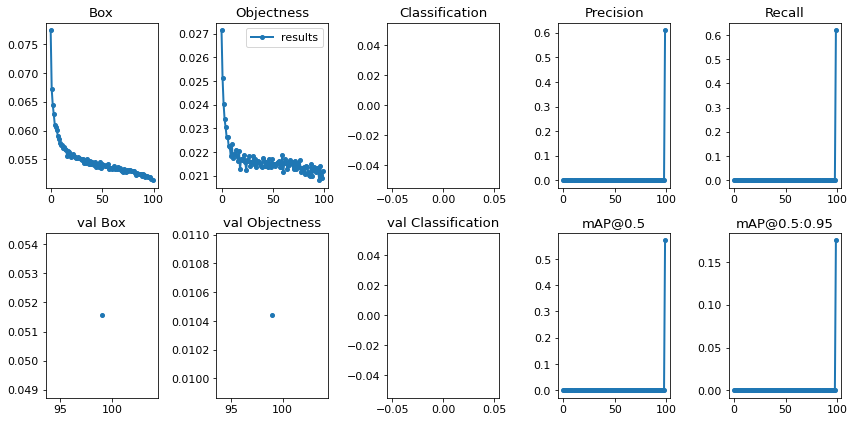

In [ ]:
from utils.plots import plot_results 
plot_results(save_dir='runs/train/exp3')  # plot all results*.txt as results.png
Image(filename='runs/train/exp3/results.png', width=800)